In [1125]:
'''This repository contains a detailed implementation of the Reinforcement Learning Enviroment class'''
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import *
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from typing import Any, Callable, Dict, List, Tuple, Union, Optional
from functools import wraps
import os
import random
from abc import ABC, abstractmethod
from collections import deque, namedtuple
T.Tensor.ndim = property(lambda self: len(self.shape))

In [1126]:
@dataclass
class EnforceClassTyping:
    def __post_init__(self):
        for (name, field_type) in self.__annotations__.items():
            if not isinstance(self.__dict__[name], field_type):
                current_type = type(self.__dict__[name])
                raise TypeError(f"The field `{name}` was assigned by `{current_type}` instead of `{field_type}`")
        # print("Check is passed successfully")
def EnforceMethodTyping(func: Callable) -> Callable:
    'Enforces type annotation/hints for class mathods'
    arg_annotations = func.__annotations__
    if not arg_annotations:
        return func

    @wraps(func)
    def wrapper(self, *args: Tuple[Any], **kwargs: Dict[str, Any]) -> Any:
        for arg, annotation in zip(args, arg_annotations.values()):
            if not isinstance(arg, annotation):
                raise TypeError(f"Expected {annotation} for argument {arg}, got {type(arg)}.")

        for arg_name, arg_value in kwargs.items():
            if arg_name in arg_annotations:
                annotation = arg_annotations[arg_name]
                if not isinstance(arg_value, annotation):
                    raise TypeError(f"Expected {annotation} for keyword argument {arg_name}, got {type(arg_value)}.")

        return func(self, *args, **kwargs)

    return wrapper
def EnforceFunctionTyping(func: Callable) -> Callable:
    'Enforces type annotation/hints for other functions'
    @wraps(func)
    def wrapper(*args, **kwargs):
        # Check positional arguments
        for arg, annotation in zip(args, func.__annotations__.values()):
            if not isinstance(arg, annotation):
                raise TypeError(f"Expected {annotation} for {arg}, got {type(arg)}.")

        # Check keyword arguments
        for arg_name, arg_value in kwargs.items():
            if arg_name in func.__annotations__:
                annotation = func.__annotations__[arg_name]
                if not isinstance(arg_value, annotation):
                    raise TypeError(f"Expected {annotation} for {arg_name}, got {type(arg_value)}.")

        return func(*args, **kwargs)

    return wrapper
 

**Ornstein Uhlenbeck Noise**

In [1127]:
class OUActionNoise(object):
    def __init__(self, mu, sigma=0.15, theta=.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(
                                                            self.mu, self.sigma)
 

**Particle**

In [1128]:
@dataclass
class Particle(EnforceClassTyping):
    'This class represents the electric field sources with its position in the field(Position) and the magnitude of the source(Charge)'
    Mass: float # kg
    Charge: float #C
    Position: T.Tensor # m
    Velocity: T.Tensor # m/s


**Particle Test**

In [1129]:
Electron= Particle(Mass=9.11e-8, Charge= -1.6e-9, Position=T.tensor([1.0, 0.0]), Velocity=T.tensor([0.0, 0.0]))
Proton= Particle(Mass=9.11e-8, Charge= 1.6e-9, Position=T.tensor([-1.0, 0.0]), Velocity=T.tensor([0.0, 0.0]))
Source= [Electron]

**Vector Field**

In [1130]:
@dataclass
class Field:
    Dimensions: int
    FieldHighBound: list[float]
    FieldLowBound: list[float]
    def __post_init__(self):
        assert  len(self.FieldHighBound) == self.Dimensions| 1, "Length of high bound and dimensions do not match"
        assert  len(self.FieldLowBound) == self.Dimensions| 1, "Length of low bound and dimensions do not match"
    @abstractmethod
    def FieldStrength(self, ObservationPosition: T.Tensor)-> T.Tensor:
        pass
    @abstractmethod
    def FieldPotential(self, ObservationPosition: T.Tensor)-> float:
        pass

class HomogenousField(Field):
    def FieldStrength(self, ObservationPosition: T.Tensor)-> T.Tensor:
        return  T.zeros((ObservationPosition.shape[0], self.Dimensions), dtype=T.float64)
    def FieldPotential(self, ObservationPosition: T.Tensor)-> float:
        return  0.0

@dataclass
class LJField:
    FieldSources: list[Particle]
    FieldHighBound: float
    FieldLowBound: float
    def __call__(self, ObservationPosition: T.Tensor)->T.Tensor:
        return self.ElectricFieldStrength(ObservationPosition)
    @EnforceMethodTyping
    def ElectricFieldStrength(self, ObservationPosition: T.Tensor)->T.Tensor:
        'This function takes a list of sources and outputs the field strength experienced at any given point(s). This determines the physics of the field(an electric field in this case)'
        CoulombConstant = 8.9875e9 #N*m^2/C^2
        for FieldSource in self.FieldSources:
            if type(FieldSource) != Particle:
                raise TypeError("The input is not valid")
        assert type(ObservationPosition) == T.Tensor, "Invalid Reference point data type"
        ElectricFieldVector = T.zeros_like(ObservationPosition)
        for FieldSource in self.FieldSources:
            PositionMatrices= T.stack([T.ones_like(ObservationPosition[0])* FieldSource.Position[0].item(), 
                                            T.ones_like(ObservationPosition[1])* FieldSource.Position[1].item()])
            DisplacementVector = ObservationPosition - PositionMatrices
            DisplacementMagnitude = T.sqrt(DisplacementVector[0]**2 +DisplacementVector[1]**2)
            ElectricFieldVector += ((FieldSource.Charge) / DisplacementMagnitude**3 * DisplacementVector) - ((FieldSource.Charge) / DisplacementMagnitude**6 * DisplacementVector)
        ElectricFieldVector= CoulombConstant *ElectricFieldVector
        return ElectricFieldVector #N/C or V/m
    @EnforceMethodTyping
    def WorkDoneAgainstField(self, InitialPosition: T.Tensor, FinalPosition: T.Tensor, resolution: int= 5000)-> float:
        '''This method determines the amount of work required to get one position to another in the field'''
        XInterval= (FinalPosition[0] - InitialPosition[0]) / resolution
        YInterval= (FinalPosition[1] - InitialPosition[1]) / resolution
        XPositions = [InitialPosition[0] + i * XInterval for i in range(resolution + 1)]
        YPositions = [InitialPosition[1] + i * YInterval for i in range(resolution + 1)]
        WorkDone = 0
        for i in range(resolution):
            PositionFieldStrength = self.ForceFieldStrength(T.Tensor([XPositions[i], YPositions[i]]))
            WorkDone += - (PositionFieldStrength[0]*XInterval + PositionFieldStrength[1]*YInterval)
        return WorkDone
    @EnforceMethodTyping
    def PlotField(self):
        'This funtion plots the 2D electric vector field'
        ObservationPosition= T.meshgrid(T.linspace(self.FieldLowBound, self.FieldHighBound, 40), 
                                        T.linspace(self.FieldLowBound, self.FieldHighBound, 40))
        ObservationPosition= T.stack(ObservationPosition)
        xd, yd = self.ElectricFieldStrength(ObservationPosition)
        xd = xd / T.sqrt(xd**2 + yd**2)
        yd = yd / T.sqrt(xd**2 + yd**2)
        color_aara = T.sqrt(xd**2+ yd**2)
        fig, ax = plt.subplots(1,1)
        cp = ax.quiver(ObservationPosition[0],ObservationPosition[1],xd,yd,color_aara)
        fig.colorbar(cp)
        plt.rcParams['figure.dpi'] = 250
        plt.show()

@dataclass
class ElectricField:
    FieldSources: list[Particle]
    FieldHighBound: float
    FieldLowBound: float
    def __call__(self, ObservationPosition: T.Tensor)->T.Tensor:
        return self.ElectricFieldStrength(ObservationPosition)
    @EnforceMethodTyping
    def ElectricFieldStrength(self, ObservationPosition: T.Tensor)->T.Tensor:
        'This function takes a list of sources and outputs the field strength experienced at any given point(s). This determines the physics of the field(an electric field in this case)'
        CoulombConstant = 8.9875e9 #N*m^2/C^2
        for FieldSource in self.FieldSources:
            if type(FieldSource) != Particle:
                raise TypeError("The input is not valid")
        assert type(ObservationPosition) == T.Tensor, "Invalid Reference point data type"
        ElectricFieldVector = T.zeros_like(ObservationPosition)
        for FieldSource in self.FieldSources:
            PositionMatrices= T.stack([T.ones_like(ObservationPosition[0])* FieldSource.Position[0].item(), 
                                            T.ones_like(ObservationPosition[1])* FieldSource.Position[1].item()])
            DisplacementVector = ObservationPosition - PositionMatrices
            DisplacementMagnitude = T.sqrt(DisplacementVector[0]**2 +DisplacementVector[1]**2)
            ElectricFieldVector += (CoulombConstant * FieldSource.Charge) / DisplacementMagnitude**3 * DisplacementVector
        return ElectricFieldVector #N/C or V/m
    @EnforceMethodTyping
    def WorkDoneAgainstField(self, InitialPosition: T.Tensor, FinalPosition: T.Tensor, resolution: int= 5000)-> float:
        '''This method determines the amount of work required to get one position to another in the field'''
        XInterval= (FinalPosition[0] - InitialPosition[0]) / resolution
        YInterval= (FinalPosition[1] - InitialPosition[1]) / resolution
        XPositions = [InitialPosition[0] + i * XInterval for i in range(resolution + 1)]
        YPositions = [InitialPosition[1] + i * YInterval for i in range(resolution + 1)]
        WorkDone = 0
        for i in range(resolution):
            PositionFieldStrength = self.ElectricFieldStrength(T.Tensor([XPositions[i], YPositions[i]]))
            WorkDone += - (PositionFieldStrength[0]*XInterval + PositionFieldStrength[1]*YInterval)
        return WorkDone
    @EnforceMethodTyping
    def PlotField(self):
        'This funtion plots the 2D electric vector field'
        ObservationPosition= T.meshgrid(T.linspace(self.FieldLowBound, self.FieldHighBound, 50), 
                                        T.linspace(self.FieldLowBound, self.FieldHighBound, 50))
        ObservationPosition= T.stack(ObservationPosition)
        xd, yd = self.ElectricFieldStrength(ObservationPosition)
        xd = xd / T.sqrt(xd**2 + yd**2)
        yd = yd / T.sqrt(xd**2 + yd**2)
        color_aara = T.sqrt(xd**2+ yd**2)
        fig, ax = plt.subplots(1,1)
        cp = ax.quiver(ObservationPosition[0],ObservationPosition[1],xd,yd,color_aara)
        fig.colorbar(cp)
        plt.rcParams['figure.dpi'] = 250
        plt.show()



**Vector Field Test**

In [1131]:
ElectricField1= ElectricField(Source, 10.0, -10.0)
# ElectricField1.PlotField()

**Environment**

In [1132]:
# should obey newtons laws in Homogenous vector field 
@dataclass
class Environment:
    @dataclass
    class State:
        pass
    InitialState: State 
    CurrentState: State 
 
    def __post_init__(self):
        pass
 
    @abstractmethod
    def StateDynamics(self, State: State, Action)-> State:
        NotImplementedError ("Subclasses should implement this method")
        pass

    @abstractmethod
    def RewardModel(self, State: State, Action, NextState: State, TerminalSignal: bool)-> float:
        NotImplementedError ("Subclasses should implement this method")
        pass

    @abstractmethod
    def IsTerminalCondition(self, State: State)-> bool:
        NotImplementedError ("Subclasses should implement this method")
        pass

    @abstractmethod
    def StateTransition(self, State: State, Action)-> tuple[float, State, bool]:
        NotImplementedError ("Subclasses should implement this method")
        pass

    @abstractmethod
    def Run(self, RunDuration: float)-> list[State]:
        NotImplementedError ("Subclasses should implement this method")
        pass
    
@dataclass
class ParticleInField(EnforceClassTyping):
    '''This class represents the environment the agent will learn from. 
    
    The UppperBoundX, LowerBoundX, UpperBoundY, and LowerBoundY determine the dimensions of the viable learning region of the environment.
    The FieldType determines the physics/dynamics of the environment
    The FieldSources shape the field '''
    Field: ElectricField
    ChargedParticle: Particle
    
    @dataclass 
    class State(EnforceClassTyping):
        '''This class represents the state of the Agent with its Position, Momentum and the Field Strength if experiences at its Position. 
        These are parameters the agent is able to observe, they uniquely define the state of the agent.'''
        Position: T.Tensor # m
        Momentum: T.Tensor #kg*m/s
        Time: float # s

        # def __add__(self, other):
        #     Position = self.Position + other.Position
        #     Momentum = self.Momentum + other.Momentum
        #     Time = self.Time + other.Time
        #     return self(Position, Momentum, Time)
    InitialState: State = None
    CurrentState: State = None
    def __post_init__(self):
        if self.InitialState is None:
            self.InitialState= self.RandomState()
        self.CurrentState= self.InitialState

    # def StateDynamics(self, State: State, Action: T.Tensor= T.tensor([0.0, 0.0])):
    #     PositionDynamics= State.Momentum/ self.ChargedParticle.Mass
    #     MomentumDynamics= (self.ChargedParticle.Charge* self.Field(State.Position))+Action
    #     TimeDynamics= 1.0
    
    @EnforceMethodTyping
    def TransitionModel(self, State: State, Action: T.Tensor= T.tensor([0.0, 0.0]), TimeInterval:float= 1, Resolution: int=30)-> State:
        '''This function determines how the state of the system changes after a given period given the agents state and parameters'''
        CurrentMomentum= State.Momentum
        CurrrentPosition= State.Position
        TimeTaken= 0
        for _ in range(Resolution):
            CurrentMomentum, CurrrentPosition= CurrentMomentum + ((self.ChargedParticle.Charge* self.Field(CurrrentPosition))+Action)*(TimeInterval/Resolution), CurrrentPosition+ (CurrentMomentum/ self.ChargedParticle.Mass)*(TimeInterval/Resolution)
            TimeTaken+= (TimeInterval/Resolution)
        CurrentTime= State.Time+ TimeTaken
        return self.State(CurrrentPosition, CurrentMomentum, CurrentTime)
    
    @EnforceMethodTyping
    def IsTerminalCondition(self, State: State)-> bool:
        '''This method determines if a position is within the viable learning region of the environment'''
        WithinXBound= self.Field.FieldLowBound <= State.Position[0] <= self.Field.FieldHighBound
        WithinYBound= self.Field.FieldLowBound <= State.Position[1] <= self.Field.FieldHighBound
        if WithinXBound or WithinYBound:
            return False    
        else:
            return True
    

    def Step(self, State: State= CurrentState, Action: T.Tensor= T.tensor([0.0, 0.0])):
        NextState= self.TransitionModel(State, Action)
        TerminalSignal= self.IsTerminalCondition(NextState) 
        return NextState, TerminalSignal
    
    @EnforceMethodTyping
    def RandomState(self)->State:
        '''This method generates a random state within the viable learning region'''
        RandomPosition= T.Tensor([np.random.uniform(self.Field.FieldLowBound, self.Field.FieldHighBound), 
                                  np.random.uniform(self.Field.FieldLowBound, self.Field.FieldHighBound)])
        RandomMomentum= T.zeros_like(RandomPosition)
        return self.State(RandomPosition, RandomMomentum, 0.0)

    def Run(self, RunDuration: float, Resolution: int=30):
        Path= []
        State= self.CurrentState
        Time= 0
        for _ in range(Resolution):
            Path.append(State.Position)
            State= self.TransitionModel(State, 1e-7* T.randn(2))
            Time += (RunDuration/Resolution)
        return Path
    
    def Lagrangian(self):
        pass
    
    def PlotRun(self, RunDuration: float):
        Path= self.Run(RunDuration)
        Path= T.stack(Path)
        Path= Path.transpose(dim0=0, dim1=1)
        # print(Path)
        t=  T.arange(0, RunDuration)
        plt.plot(Path[0], Path[1])
        plt.plot(Path[0][0], Path[1][0], 'ko')
        plt.plot(Path[0][-1], Path[1][-1], 'r*')
        plt.xlim(-10,10)
        plt.ylim(-10,10)
        plt.grid(True)
        plt.show()

    def Reset(self):
        self.CurrentState= self.Start

**Environment Test**

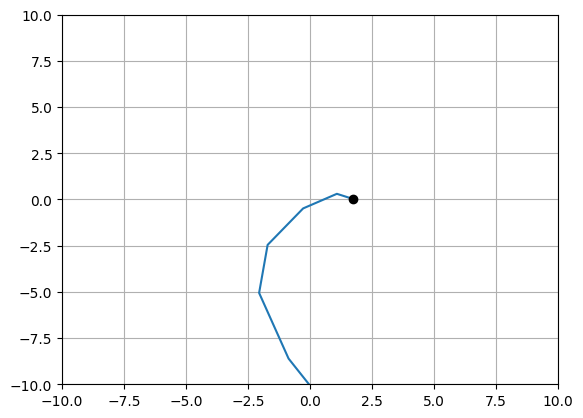

In [1133]:
Environment1= ParticleInField(ElectricField1, Proton)
Environment1.PlotRun(20)
# -(Environment.ChargedParticle.Charge* Environment.Field(Environment.CurrentState.Position))
# Environment.Step(Environment.CurrentState,T.tensor([1e-9, 1e-9]))

**Critic Network**

In [1134]:
class CriticNetwork(nn.Module):
    def __init__(self, learning_rate, state_dims, fc1_dims, fc2_dims, n_actions, name, chkpt_dir='tmp/ddpg'):
        super(CriticNetwork, self).__init__() 
        self.checkpoint_file = os.path.join(chkpt_dir,name+'_ddpg')

        self.fc1 = T.nn.utils.parametrizations.weight_norm(nn.Linear(state_dims+n_actions, fc1_dims)) 
        self.bn1 = nn.LayerNorm(fc1_dims)
        self.fc2 = T.nn.utils.parametrizations.weight_norm(nn.Linear(fc1_dims, fc2_dims))
        self.bn2 = nn.LayerNorm(fc2_dims)
        self.fc3 = T.nn.utils.parametrizations.weight_norm(nn.Linear(fc2_dims, 1))

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state, action):
        x = T.cat([state, action], dim=-1)
        x = T.relu(self.bn1(self.fc1(x)))
        x = T.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))
 

**Critic Network Test**

In [1135]:
N= CriticNetwork(0.02, 5, 10, 15, 2, name='tb')

bt= T.tensor([[-1.4355, -0.7806,  0.3042,  1.1601, -0.1184]])
at= T.tensor([[0.8233, 0.8126]])
# for target_param in N.parameters():
#     print(target_param) 
# bt, m(bt), N(bt)
N.load_checkpoint()
bt, at, N(bt, at)

... loading checkpoint ...


(tensor([[-1.4355, -0.7806,  0.3042,  1.1601, -0.1184]]),
 tensor([[0.8233, 0.8126]]),
 tensor([[0.6215]], grad_fn=<AddmmBackward0>))

**Actor Network**

In [1136]:
class ActorNetwork(nn.Module):
    def __init__(self, learning_rate, state_dims, fc1_dims, fc2_dims, n_actions, name, chkpt_dir='tmp/ddpg'):
        super(ActorNetwork, self).__init__()
        self.checkpoint_file = os.path.join(chkpt_dir,name+'_ddpg')

        self.fc1 = T.nn.utils.parametrizations.weight_norm(nn.Linear(state_dims , fc1_dims)) 
        self.bn1 = nn.LayerNorm(fc1_dims)
        self.fc2 = T.nn.utils.parametrizations.weight_norm(nn.Linear(fc1_dims, fc2_dims))
        self.bn2 = nn.LayerNorm(fc2_dims)
        self.fc3 = T.nn.utils.parametrizations.weight_norm(nn.Linear(fc2_dims, n_actions))

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = T.relu(self.bn1(self.fc1(state)))
        x = T.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))


**Actor Network Test**

In [1137]:
Nt= ActorNetwork(0.02, 5, 10, 15, 2, name='btt')

btt= T.tensor([[-0.6552,  0.0852,  2.0087, -0.6352,  0.4445]])
att= T.randn(1, 2)
# for target_param in N.parameters():
#     print(target_param) 
# bt, m(bt), N(bt)
Nt.load_checkpoint()
btt, Nt(btt)

... loading checkpoint ...


(tensor([[-0.6552,  0.0852,  2.0087, -0.6352,  0.4445]]),
 tensor([[-0.5010,  0.0301]], grad_fn=<AddmmBackward0>))

In [1138]:
@dataclass 
class ReplayBuffer:
    '''This class represents the Replay buffer which stores state transitions(State, Action, NextState, Reward, Terminal Signal) which will be used to train the Actor and Critic Networks. 
    The replay buffer'''
    BufferSize: int
    Buffer: list = None
    def __post_init__(self):
        if self.Buffer is None:
            self.Buffer = []
    def AddExperience(self, State, Action, NextState, Reward: float, TerminalState: bool):
        '''This method adds a state transition to the replay buffer'''
        if len(self.Buffer) < self.BufferSize:
            self.Buffer.append({'State': State, 'Action': Action, 'NextState': NextState, 'Reward': Reward, 'TerminalState': TerminalState})
        else:
            self.Buffer.pop(0)
            self.Buffer.append({'State': State, 'Action': Action, 'NextState': NextState, 'Reward': Reward, 'TerminalState': TerminalState})
    def SampleBuffer(self, BatchSize: int):
        '''This method randomly samples the replay buffer to ouput a batches of state transition variables'''
        if len(self.Buffer) >= BatchSize:
            SampledBatch = random.sample(self.Buffer, BatchSize)
            SampledStates= [SampledState[0].Unwrap() for SampledState in SampledBatch]
            SampledActions= [SampledAction[1] for SampledAction in SampledBatch]
            SampledNextStates= [SampledNextState[2].Unwrap() for SampledNextState in SampledBatch]
            SampledRewards= [T.Tensor([SampledReward[3]]) for SampledReward in SampledBatch]
            SampledTerminalSignals= [T.Tensor([SampledTerminalSignal[4]]) for SampledTerminalSignal in SampledBatch]
            StateBatch= T.stack(SampledStates)
            ActionBatch= T.stack(SampledActions)
            NextStateBatch= T.stack(SampledNextStates)
            RewardsBatch= T.stack(SampledRewards)
            TerminalSignalsBatch= T.stack(SampledTerminalSignals)
 
        return StateBatch, ActionBatch, NextStateBatch, RewardsBatch, TerminalSignalsBatch
    def __len__(self):
        return len(self.Buffer)


In [1139]:
rt=ReplayBuffer(10)


In [1140]:
@dataclass
class Agent:
    AgentEnvironment: Environment

    def __post_init__(self):
        pass
    @abstractmethod
    def Act(self, Observation: T.Tensor)-> T.Tensor:
        NotImplementedError ("Subclasses must implement the `Act` method")
        pass
    @abstractmethod
    def Observe(self)-> T.Tensor:
        NotImplementedError ("Subclasses must implement the `Act` method")
        pass
    
    @abstractmethod
    def Learn(self):
        'Improves  the agent by updating its models'
        pass
    @abstractmethod
    def LearningAlgorithm(self):
        pass
    
class Agent(object):
    def __init__(self, lr_actor, lr_critic, input_dims, tau, env, Target,
                 gamma=0.99, n_actions=2, max_size=1000, layer1_size=20, layer2_size=15, batch_size=16, time_step= 0.5):
        self.actor = ActorNetwork(lr_actor, input_dims, layer1_size, layer2_size, n_actions=n_actions, name='Actor')
        self.critic = CriticNetwork(lr_critic, input_dims, layer1_size, layer2_size, n_actions=n_actions, name='Critic')
        self.target_actor = ActorNetwork(lr_actor, input_dims, layer1_size, layer2_size, n_actions=n_actions, name='TargetActor')
        self.target_critic = CriticNetwork(lr_critic, input_dims, layer1_size, layer2_size, n_actions=n_actions, name='TargetCritic')
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        # self.memory = ReplayBuffer(max_size)
        self.memory = deque(maxlen=max_size)
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.env: ParticleInField= env
        self.noise = OUActionNoise(mu=np.zeros(n_actions))
        self.time_step= time_step
        Target: T.Tensor= Target
        DistanceWeight: float= 0.5
        EnergyWeight: float= 0.5
        TerminalSignalWeight: float= 0.5
        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        self.actor.eval()
        observation = T.tensor(observation, dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(observation).to(self.actor.device)
        mu_prime = mu + T.tensor(self.noise(), dtype=T.float).to(self.actor.device)
        self.actor.train()
        return mu_prime.cpu().detach()

    def Observe(self):
        State= self.env.CurrentState 
        Observation= T.cat([State.Position,
                          State.Momentum,
                          T.tensor([State.Time])])
        return Observation
    
    def RewardModel(self, State , Action , NextState , TerminalSignal )-> float:
        '''This method determines how the agent is rewarded given a state transition. The reward determines the behaviour the agent should learn(i.e getting to the target and using the least amount of energy).'''
        DistanceGainedFromTarget= T.norm(State.Position-self.Target)- T.norm(NextState.Position-self.Target) 
        EnergyConsumed= self.Field.WorkDoneAgainstField(State.Position, NextState.Position)
        Cost= self.DistanceWeight* DistanceGainedFromTarget+ self.EnergyWeight* EnergyConsumed+ self.TerminalSignalWeight* TerminalSignal+ 1.0
        return -Cost.item()
    
    def DDPGAlgorithm(self):
        score_history = []
        for i in range(100):
            self.env.CurrentState = self.env.InitialState
            done = False
            score = 0
            for _ in range(100):
                observation= self.Observe()
                Action = self.choose_action(observation)
                new_state, done= self.env.Step(self.env.CurrentState, Action)
                reward= self.RewardModel(self.env.CurrentState, Action, new_state, done)
                self.memory.append((self.env.CurrentState, Action, new_state, reward, int(done)))
                # self.memory.AddExperience(CurrentState, Action, new_state, reward, int(done)) 
                self.learn()
                score += reward
                # print(reward)
                self.env.CurrentState = new_state
            score_history.append(score)
        plt.plot(score_history)
        return score_history
        
    def learn(self):
        if len(self.memory) < self.batch_size:
            return
        # state, action, new_state, reward, done = self.memory.SampleBuffer(self.batch_size)

        # reward = T.tensor(reward, dtype=T.float).to(self.critic.device)
        # done = T.tensor(done).to(self.critic.device)
        # new_state = T.tensor(new_state, dtype=T.float).to(self.critic.device)
        # action = T.tensor(action, dtype=T.float).to(self.critic.device)
        # state = T.tensor(state, dtype=T.float).to(self.critic.device)
        batch = random.sample(self.memory, self.batch_size)
        states, actions, next_states, rewards, dones = zip(*batch)
        # print(states)
        # print(actions)
        # print(next_states)
        # print(T.tensor(rewards, dtype=T.float).unsqueeze(1) )
        # print(T.tensor(dones, dtype=T.float).unsqueeze(1) )
        state = T.stack(states).to(self.critic.device)
        action = T.stack(actions).to(self.critic.device)
        reward = T.tensor(rewards, dtype=T.float).unsqueeze(1).to(self.critic.device)
        new_state = T.stack(next_states).to(self.critic.device)
        done = T.tensor(dones, dtype=T.float).unsqueeze(1).to(self.critic.device)

        self.target_actor.eval()
        self.target_critic.eval()
        self.critic.eval()
        
        target_actions = self.target_actor.forward(new_state)
        critic_value_ = self.target_critic.forward(new_state, target_actions)

        q_expected = self.critic.forward(state, action)
        q_targets = reward + self.gamma * critic_value_ * (1 - done)

        critic_loss = nn.MSELoss()(q_expected, q_targets.detach())
        self.critic.train()
        self.critic.optimizer.zero_grad()
        critic_loss.backward()
        self.critic.optimizer.step()

        self.critic.eval()
        self.actor.optimizer.zero_grad()
        mu = self.actor.forward(state)
        self.actor.train()
        actor_loss = -self.critic.forward(state, mu)
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()
    
    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_dict = dict(target_critic_params)
        target_actor_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + (1-tau)*target_critic_dict[name].clone()
        self.target_critic.load_state_dict(critic_state_dict)

        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + (1-tau)*target_actor_dict[name].clone()
        self.target_actor.load_state_dict(actor_state_dict)

        """
        #Verify that the copy assignment worked correctly
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(target_critic_params)
        actor_state_dict = dict(target_actor_params)
        print('\nActor Networks', tau)
        for name, param in self.actor.named_parameters():
            print(name, T.equal(param, actor_state_dict[name]))
        print('\nCritic Networks', tau)
        for name, param in self.critic.named_parameters():
            print(name, T.equal(param, critic_state_dict[name]))
        input()
        """
    
    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()

    def check_actor_params(self):
        current_actor_params = self.actor.named_parameters()
        current_actor_dict = dict(current_actor_params)
        original_actor_dict = dict(self.original_actor.named_parameters())
        original_critic_dict = dict(self.original_critic.named_parameters())
        current_critic_params = self.critic.named_parameters()
        current_critic_dict = dict(current_critic_params)
        print('Checking Actor parameters')

        for param in current_actor_dict:
            print(param, T.equal(original_actor_dict[param], current_actor_dict[param]))
        print('Checking critic parameters')
        for param in current_critic_dict:
            print(param, T.equal(original_critic_dict[param], current_critic_dict[param]))
        input()
agent = Agent(0.000025, 0.00025, 5, 0.001, Environment1, T.tensor([1.0, 1.0]))
agent.DDPGAlgorithm()

/var/folders/qw/w54k7dcj4mlftnk6g2k3ys1w0000gn/T/ipykernel_17191/3012710907.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  observation = T.tensor(observation, dtype=T.float).to(self.actor.device)


AttributeError: 'Agent' object has no attribute 'Target'